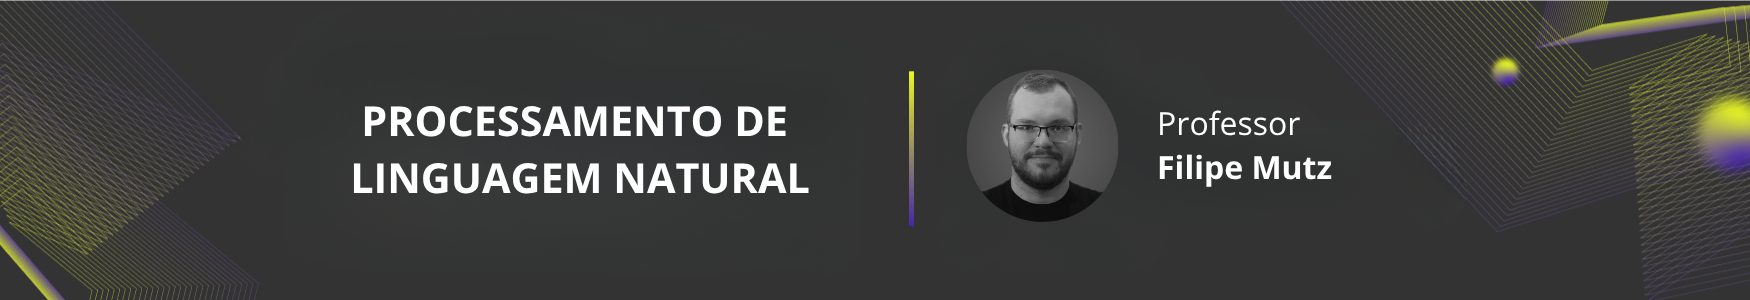

# 📝🤖 Redes Long Short-Term Memory (LSTM)

Neste notebook, vamos estudar:
- Por que é difícil treinar RNNs "vanilla".
- O que são redes neurais Long Short-Term Memory (LSTM).
- Como LSTMs superam as limitações de RNNs simples.
- Como implementar LSTMs do zero usando Pytorch.
- Como utilizar LSTMs pré-definidas no pytorch.

### O Problema dos Gradientes que Explodem ou Desvanecem


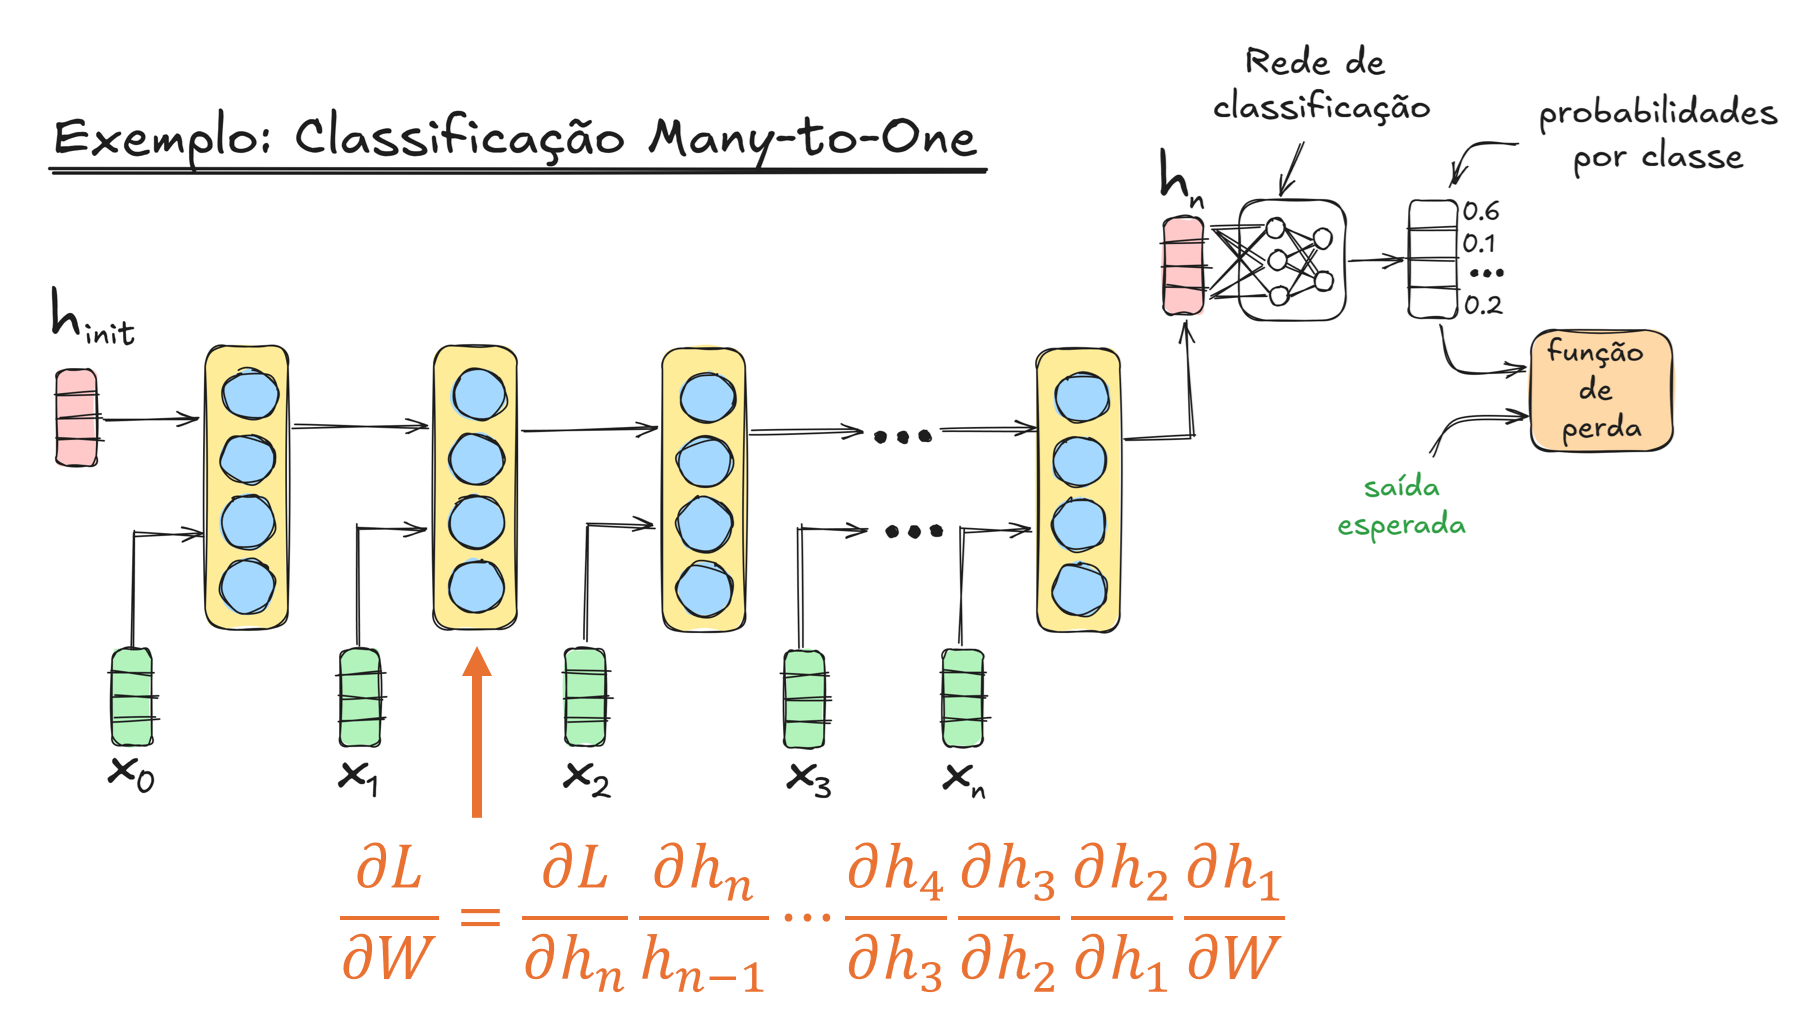


Precisamos calcular a derivada parcial da função de perda em relação aos parâmetros da RNN para treinar a rede. Como os parâmetros são compartilhados entre instantes, o gradiente será dado pela soma dos gradientes para cada instante de tempo.

$$\frac{\partial L}{\partial W} = \sum_{t=1}^{T} \frac{\partial L}{\partial h_t} \frac{\partial h_t}{\partial W}$$

Contudo, para calcular o gradiente em relação a um estado $h_t$, os gradientes precisam ser propagados no tempo através da regra da cadeia.

$$\frac{\partial L}{\partial h_t} =  \frac{\partial L}{\partial h_n} \frac{\partial h_n}{\partial h_{n-1}} \cdots \frac{\partial h_{t+1}}{\partial h_t}$$

Este produto de vários termos torna o treinamento de RNNs bastante desafiador e pode levar aos seguintes problemas:

* **Gradientes que Desvanecem (Vanishing Gradients):** Se a maioria dos fatores é menor que um, o produto se torna extremamente pequenos, impedindo que os pesos das camadas iniciais sejam atualizados efetivamente.
* **Gradientes que Explodem (Exploding Gradients):** Por outro lado, se a maioria dos fatores é maior que um, o produto se torna excessivamente grandes, levando a atualizações de peso instáveis e divergência do modelo.

Estes problemas são particularmente proeminentes em sequências longas. O problema da explosão pode ser mitigada usando a técnica de ***gradient clipping*** ("cortar" o valor do gradiente se ele ultrapassar um limiar), contudo lidar com o problema de gradientes que desvanecem não é trivial. O efeito prático é que bastante difícil fazer a rede ser sensível a dados que estão longe no passado.

## Long Short-Term Memory (LSTM)

As camadas do tipo Long Short-Term Memory (LSTM) são tipos de RNNs que lidam com o problema dos *vanishing gradients*. Para isto, o estado em duas partes:

- $c_{t-1}$: vetor de "memória" do instante $t-1$.
- $h_{t-1}$: vetor de estado oculto do instante $t-1$.

Ambos estes vetores são usados como entrada para a camada recorrente junto com o vetor de entrada $x_t$.

Além disto, é criado um caminho $C_{t-1} \rightarrow C_t$ que não passa por não-linearidades. Este caminho permite um melhor tráfego de informação na fase *forward* e de gradientes na fase *backward*.

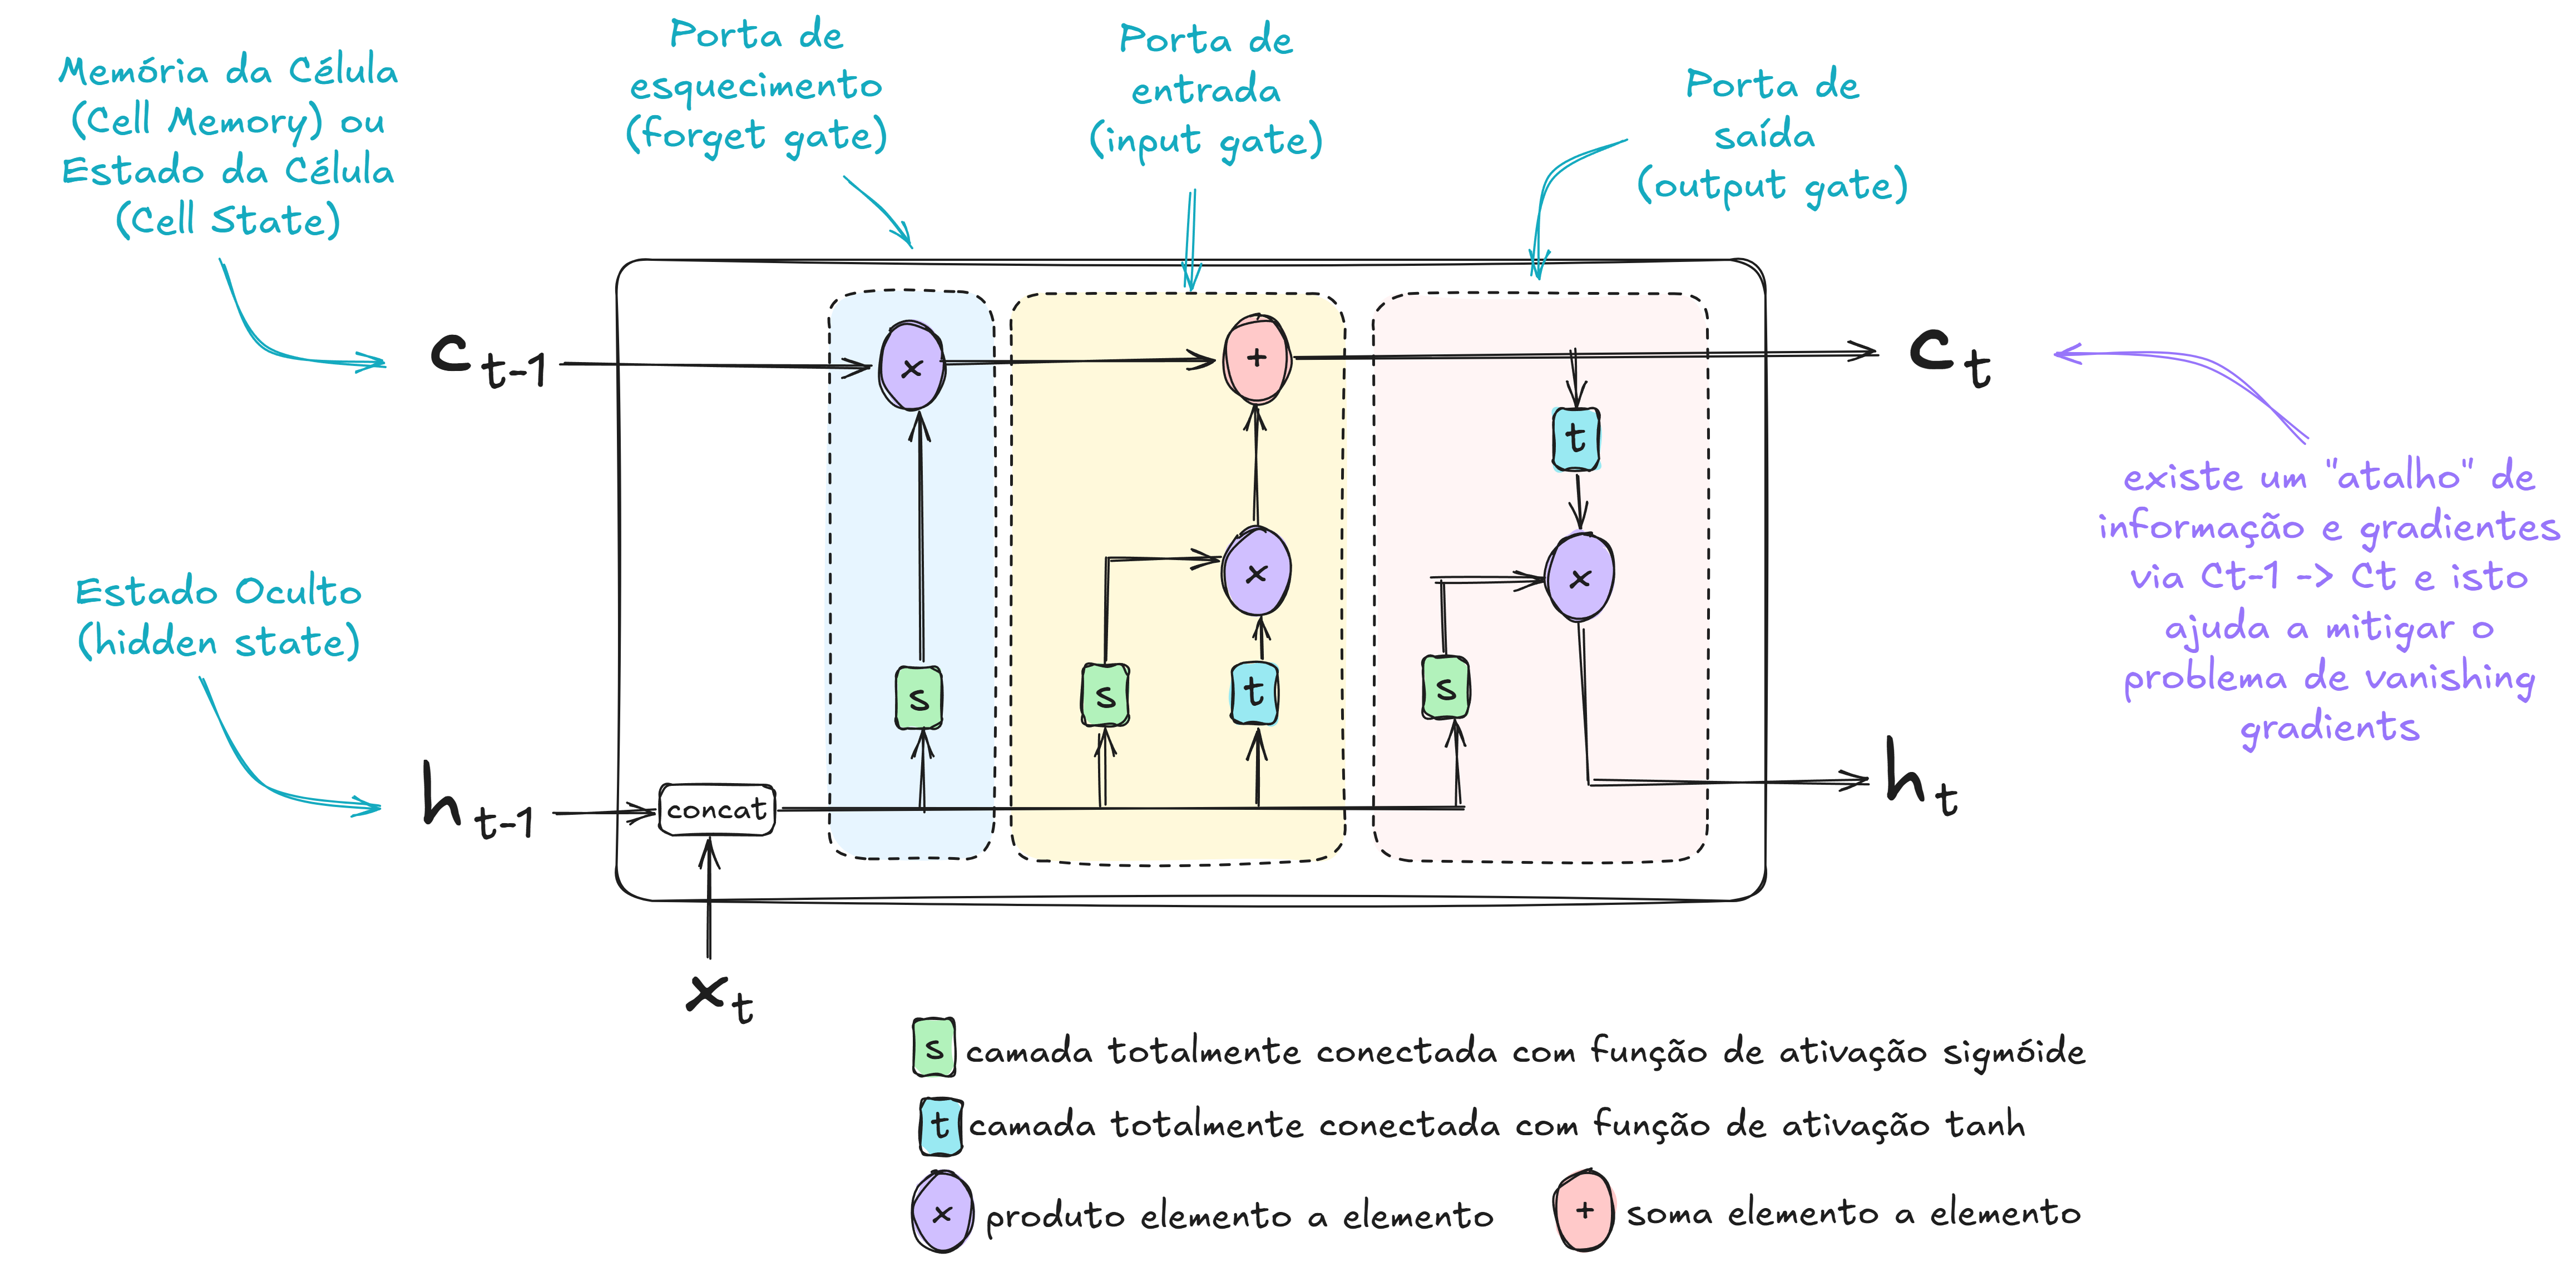


As redes LSTM possuem alguns componentes que, considerando $x_t$ e $h_{t-1}$, definem que informações devem ser removidas, inseridas e extraídas da memória para serem adicionadas a $h_t$:

  - **Porta de esquecimento (f_t)**: decide o que esquecer da memória.
  - **Porta de entrada (i_t)**: decide o que guardar na memória.
  - **Porta de saída (o_t)**: decide que partes da memória incorporar no estado e retornar.

Estes componentes são implementados usando camadas totalmente conectadas seguidas de funções não lineares.

### Formulação Matemática

As operações são precisamente definidas por:


$ i_t = \sigma(W_i [h_{t-1}, x_t] + b_i)  \hspace{1 cm} \rhd \text{(porta de entrada)} $

$ f_t = \sigma(W_f [h_{t-1}, x_t] + b_f)  \hspace{1 cm} \rhd \text{(porta de esquecimento)} $

$\tilde{C}_t = \tanh(W_C [h_{t-1}, x_t] + b_C)  \hspace{1 cm} \rhd \text{(proposta de dados a serem inseridos na memória)} $

$ C_t = f_t * C_{t-1} + i_t * \tilde{C}_t  \hspace{1 cm} \rhd \text{(atualização do estado de célula)}$



$ o_t = \sigma(W_o [h_{t-1}, x_t] + b_o)  \hspace{1 cm} \rhd \text{(porta de saída)} $

$ h_t = o_t * \tanh(C_t)  \hspace{1 cm} \rhd \text{(novo estado oculto / saída do LSTM)} $


Aqui, $i_t,f_t,o_t$ são vetores de valores entre 0 e 1 (das sigmoides) que controlam o quanto entrar, esquecer ou sair da célula. O vetor $\tilde{C}t$ é o candidato a ser adicionado ao estado. A célula de memória $C_t$ acumula informações relevantes ao longo do tempo, e o estado oculto $h_t$ (a saída) é determinado pela porta de saída $o_t$ e a memória.

⚠️ **IMPORTANTE** ⚠️: LSTMs possuem uma grande quantidade de parâmetros e treinar a rede sem sofrer de *overfitting* não é tão direto quanto treinar redes *feed-forward*.

## Implementando LSTMs do Zero usando Pytorch

A célula abaixo mostra como implementar uma rede LSTM usando Pytorch.

In [ ]:
import torch
import torch.nn as nn

class LSTMLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMLayer, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        combined_size = input_size + hidden_size

        # Linear layers para cada uma das portas: f, i, C_tilda, o
        self.linear_forget = nn.Linear(combined_size, hidden_size)
        self.linear_input = nn.Linear(combined_size, hidden_size)
        self.linear_new_C = nn.Linear(combined_size, hidden_size)
        self.linear_output = nn.Linear(combined_size, hidden_size)

        # Inicialização dos pesos com distribuição normal
        for linear in [self.linear_forget, self.linear_input, self.linear_new_C, self.linear_output]:
            nn.init.normal_(linear.weight, mean=0.0, std=0.1)
            nn.init.normal_(linear.bias, mean=0.0, std=0.1)

    def forward(self, x, hidden):
        h_prev, C_prev = hidden  # Cada um: (batch, hidden_size)
        combined = torch.cat((h_prev, x), dim=1)  # (batch, input_size + hidden_size)

        f_t = torch.sigmoid(self.linear_forget(combined))
        i_t = torch.sigmoid(self.linear_input(combined))
        C_tilde = torch.tanh(self.linear_new_C(combined))
        C_t = f_t * C_prev + i_t * C_tilde
        o_t = torch.sigmoid(self.linear_output(combined))
        h_t = o_t * torch.tanh(C_t)

        return h_t, C_t

    def init_hidden(self, batch_size):
        return (
            torch.zeros(batch_size, self.hidden_size),
            torch.zeros(batch_size, self.hidden_size)
        )

input_size = 1
hidden_size = 3
lstm = LSTMLayer(input_size, hidden_size)
lstm

LSTMLayer(
  (linear_forget): Linear(in_features=4, out_features=3, bias=True)
  (linear_input): Linear(in_features=4, out_features=3, bias=True)
  (linear_new_C): Linear(in_features=4, out_features=3, bias=True)
  (linear_output): Linear(in_features=4, out_features=3, bias=True)
)

A camada pode ser utilizada como indicado abaixo.

In [ ]:

batch_size = 1

x = torch.randn(batch_size, input_size)

h0, C0 = lstm.init_hidden(batch_size)
h1, C1 = lstm(x, (h0, C0))
h2, C2 = lstm(x, (h1, C1))
h3, C3 = lstm(x, (h2, C2))

print("Saída h3:", h3)
print("Estado de célula C3:", C3)


Saída h3: tensor([[-0.0778,  0.1258, -0.0173]], grad_fn=<MulBackward0>)
Estado de célula C3: tensor([[-0.1434,  0.2563, -0.0326]], grad_fn=<AddBackward0>)


## Usando o tipo LSTM já definido no Pytorch

A célula abaixo demonstra como utilizar camadas do tipo LSTM pré-definidas. Elas recebem como entrada um batch de sequências e iteram sobre as sequências internamente. O resultado é composto por três elementos:

- **all_hs**: estados ocultos para todos os instantes de tempo: $[h_0, \cdots, h_n]$.
- **hn**: estado oculto ao final da sequência: $h_n$ (último elemento do item anterior).
- **cn**: memória ao final da sequência: $C_n$.

‼️**IMPORTANTE**: Mesmo usando `batch_first=True`, $h_n$ terá como shape `[seq_length, batch_size, hidden_size]`.

In [ ]:
import torch.nn as nn

batch_size = 1
seq_length = 5
input_size = 2
hidden_size = 3

# batch de exemplo inicializado com valores aleatórios
batch_seqs = torch.randn(batch_size, seq_length, input_size)

# camada LSTM
lstm = nn.LSTM(input_size, hidden_size, batch_first=True)

# passa um batch de sequências como entrada para a LSTM
# e gera como saída os estados para todos os intantes, além
# do estado e memória da célula ao final das sequências.
all_hs, (hn, Cn) = lstm(batch_seqs)

print(f"all_hs.shape: {all_hs.shape} all_hs: {all_hs}")
print(f"hn.shape: {hn.shape} hn: {hn}")
print(f"Cn.shape: {Cn.shape} Cn: {Cn}")


hs.shape: torch.Size([1, 5, 3]) hs: tensor([[[ 0.2049, -0.2284,  0.2502],
         [ 0.2022,  0.0144,  0.2558],
         [ 0.2205,  0.0539,  0.3354],
         [ 0.2817, -0.0071,  0.3679],
         [ 0.2384,  0.0581,  0.2800]]], grad_fn=<TransposeBackward0>)
hn.shape: torch.Size([1, 1, 3]) hn: tensor([[[0.2384, 0.0581, 0.2800]]], grad_fn=<StackBackward0>)
Cn.shape: torch.Size([1, 1, 3]) Cn: tensor([[[0.8375, 0.1768, 0.6525]]], grad_fn=<StackBackward0>)


---

No próximo vídeo, vamos ver como utilizar _word embeddings_ e LSTMs para análise de sentimentos em textos.